In [1]:
from ABCD_ML import *
import pandas as pd
import os

In [2]:
# Base data directories, 2.0 release with most of the phenotype information
main_dr = '/home/sage/work/'

nda_dr = main_dr + 'ABCD2p0NDA/'

# This folder contains the re-released 2.0.1 fixed MRI derived measurements
nda_dr2 = main_dr + 'ABCDFixRelease2p0p1'

#This file stores the name mapping
map_file = os.path.join(nda_dr2, 'Fix Release Notes 2.0.1_Public', '24. ABCD_Release_2.0.1_Updates',
                        'abcd_2.0.1_mapping.csv')

# Destr atlas structural MRI rois
data1 = os.path.join(nda_dr2, 'mrisst02.txt')
data2 = os.path.join(nda_dr2,'abcd_tfsstabwdp101.txt')
data3 = os.path.join(nda_dr2, 'abcd_tfsstabwdp201.txt')

# Family ID
strat1 = os.path.join(nda_dr, 'acspsw03.txt')

# This file contains the NIH toolbox scores
target_loc = nda_dr + 'abcd_sst02.txt'

exp_name = Exp
log_dr = None
existing_log = append
verbose = True
exp log dr setup at: None
log file at: None
notebook = True
use_default_subject_ids = False
low memory mode = False
strat_u_name = _Strat
random state = 1
ABCD_ML object initialized
Total excluded subjects:  1513
Removed excluded subjects from loaded dfs
Setting default load params, as they have not been set!

Default load params set within self.default_load_params.
----------------------
dataset_type: basic
subject_id: src_subject_id
eventname: None
eventname_col: eventname
overlap_subjects: False
na_values: ['777', '999']
drop_na: True
drop_or_na: drop

To change the default load params, call self.Set_Default_Load_Params()

Loading /home/sage/work/ABCDFixRelease2p0p1/Fix Release Notes 2.0.1_Public/24. ABCD_Release_2.0.1_Updates/abcd_2.0.1_mapping.csv  with dataset type: explorer
Loading new name_map from file!
Cleared loaded data.

Loading /home/sage/work/ABCDFixRelease2p0p1/mrisst02.txt  with dataset type: basic
dropp

,tfmri_sst_all_beh_total_mean.rt
count,7281.000000
mean,303.026513
std,67.097403
min,84.338667
25%,259.278940
50%,301.126984
75%,345.684015
max,500.778677


Num. of unique vals: 7276



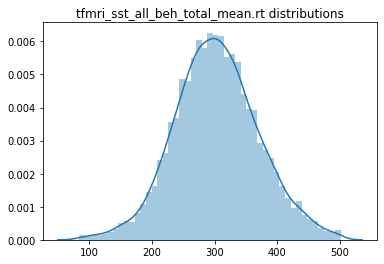


Loading /home/sage/work/ABCDFixRelease2p0p1/mrisst02.txt  with dataset type: basic
Dropped 0 cols for all missing values
Dropped 1 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0
loading: sex
loaded shape:  (7734, 1)

Total valid overlapping subjects = 7280

Loading /home/sage/work/ABCDFixRelease2p0p1/mrisst02.txt  with dataset type: basic
Dropped 0 cols for all missing values
Dropped 1 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0

Total valid overlapping subjects = 7280

Loading /home/sage/work/ABCDFixRelease2p0p1/mrisst02.txt  with dataset type: basic
Dropped 0 cols for all missing values
Dropped 0 rows for missing values, based on the provided drop_na param: True with actual na_thresh: 0
Loaded rows with NaN remaining: 0
Merged with existing!
New combined shape: (7734, 2)

Total valid overlapping subjects = 7280

Preparing fi

In [3]:
ML = ABCD_ML(log_dr = None,
             existing_log = 'append',
             notebook = True,
             random_state = 1)

# Exclude subjects w/ data from philips scanners
ML.Load_Exclusions('philips.txt')

ML.Load_Name_Map(loc = map_file,
                 dataset_type= 'explorer',
                 source_name_col= 'nda_name',
                 target_name_col= 'deap_name')

# These drop keys are to narrow in on only the subcortical volumes of interest
drop_keys = ['_csf', '.white.matter', '.vent', '_cort.desikan_', 'all_beta']

# These are to specify the contrasts we want to load
contrast_keys = ['tfmri_sst_all_correct.go.vs.fixation_beta_', 
                 'tfmri_sst_all_correct.stop.vs.correct.go_beta_',
                 'tfmri_sst_all_incorrect.stop.vs.correct.go_beta_']

ML.Load_Data(loc = [data1,data2,data3],
             inclusion_keys = contrast_keys,
             drop_keys=drop_keys,
             clear_existing=True,
             subject_id='src_subject_id',
             dataset_type = 'basic',
             filter_outlier_std = 10)

ML.Load_Targets(target_loc,
                dataset_type='basic',
                col_name='tfmri_sst_all_beh_total_meanrt',
                data_type='float',
                filter_outlier_percent=(.015, .99),
                clear_existing=True)

ML.Show_Targets_Dist()

ML.Load_Covars(loc = data1,
               col_name = 'sex',
               data_type = 'b')

ML.Load_Strat(loc = data1,
              col_name = 'sex')

ML.Load_Strat(loc = data1,
              col_name = 'interview_age',
              float_col = True,
              float_bins = 2,
              float_bin_strategy = 'quantile')

ML.Train_Test_Split(test_size=0.2,
                    random_state=1001)

scaler = Scaler(obj = 'robust regressor',
                scope = 'float',
                params = 1)

model = Model('ridge', params=1)

search = Param_Search(splits = 3,
                      n_iter = 20)

fi = Feat_Importance('shap')

pipeline = Model_Pipeline(scalers = scaler,
                          model = model,
                          param_search = search,
                          feat_importances = fi)

In [4]:
model1 = Model('ridge',
               params = 1)

model2 = Model('linear',
               params = 0)

model = Select([model2, model1])
m = Select([model2, model])

scaler1 = Scaler(obj = 'standard')
scaler2 = Scaler(obj = 'minmax')

param_search = Param_Search(n_iter=2)

model_pipeline = Model_Pipeline(model = m,
                                scalers = [Select([scaler1, scaler1]), scaler2],
                                param_search = param_search)

In [5]:
problem_spec = Problem_Spec(problem_type = 'regression',
                            metric = 'r2',
                            random_state = 2,
                            n_jobs = 1)

In [6]:
ML.Set_Default_ML_Verbosity(best_params = True)

Default ML verbosity set within self.default_ML_verbosity.
----------------------
save_results: False
progress_bar: True
compute_train_score: False
show_init_params: True
fold_name: False
time_per_fold: False
score_per_fold: False
fold_sizes: False
best_params: True
save_to_logs: False



In [7]:
results = ML.Evaluate(model_pipeline = model_pipeline,
                      problem_spec = problem_spec,
                      n_repeats = 1,
                      splits = 2)

Model_Pipeline
--------------
scalers=\
[Select([Scaler(extra_params={}, obj='standard', params=0, scope='float'),
         Scaler(extra_params={}, obj='standard', params=0, scope='float')]),
 Scaler(extra_params={}, obj='minmax', params=0, scope='float')]

model=\
Select([Model(extra_params={}, obj='linear', params=0),
        Select([Model(extra_params={}, obj='linear', params=0),
                Model(extra_params={}, obj='ridge', params=1)])])

param_search=\
Param_Search(metric='default', n_iter=2, n_repeats=1,
             search_type='RandomSearch', splits=3, weight_metric=False)

feat_importances=\
Feat_Importance(metric='default', n_perm=10, obj='base', shap_params=None)


Problem_Spec
------------
problem_type = regression
target = tfmri_sst_all_beh_total_mean.rt
metric = r2
weight_metric = False
scope = all
subjects = all
len(subjects) = 7280 (before overlap w/ train/test subjects)
n_jobs 1
random_state 2

Evaluate Params
---------------
splits = 2
n_repeats = 1
train_subjec

Params Selected by Best Pipeline:
scalers
scalers_selector0__selected: 0

model
models_selector0__selected: 1
models_selector0__models_selector0__selected: 1
models_selector0__models_selector0__ridge regressor__alpha: 0.21858274948873047

Params Selected by Best Pipeline:
scalers
scalers_selector0__selected: 0

model
models_selector0__selected: 1
models_selector0__models_selector0__selected: 1
models_selector0__models_selector0__ridge regressor__alpha: 0.21858274948873047




Validation Scores
_________________
Metric:  r2
Mean Validation score:  -0.03682098591341654
Std in Validation score:  0.023965293832641343

